In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, InputLayer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

print(tf.executing_eagerly())

True


In [3]:
mnist = tf.keras.datasets.mnist
(train_images_mnist, train_labels_mnist), (test_images_mnist, test_labels_mnist) = mnist.load_data()

cifar10 = tf.keras.datasets.cifar10
(train_images_cifar10, train_labels_cifar10), (test_images_cifar10, test_labels_cifar10) = cifar10.load_data()

fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images_fashion_mnist, train_labels_fashion_mnist), (test_images_fashion_mnist, test_labels_fashion_mnist) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
mnist_training_parameters = {'dataset': train_images_mnist / 255.0,
                             'learning_rate': 0.0005,
                             'epochs': 1000,
                             'batch_size': 200}

cifar10_training_parameters = {'dataset': train_images_cifar10 / 255.0,
                             'learning_rate': 0.00001,
                             'epochs': 1000,
                             'batch_size': 200}

fashion_mnist_training_parameters = {'dataset': train_images_fashion_mnist / 255.0,
                             'learning_rate': 0.0005,
                             'epochs': 1000,
                             'batch_size': 200}

In [5]:
mnist_parameters = {'input_dim': (28,28,1),
                    'latent_dim': 8}

cifar10_parameters = {'input_dim': train_images_cifar10[0].shape,
                    'latent_dim':12}

fashion_minst_parameters = {'input_dim': train_images_fashion_mnist[0].shape,
                    'latent_dim':12}

In [6]:
# MNIST architecture

mnist_encoder = tf.keras.Sequential([
                InputLayer(input_shape = mnist_parameters['input_dim']),
                Conv2D(32, (3, 3), activation='relu'),
                Conv2D(64, (3, 3), activation='relu'),
                Flatten(),
                Dense(128, activation='relu'),
                Dense(mnist_parameters['latent_dim'], activation=None)
            ])

mnist_decoder = tf.keras.Sequential([
                InputLayer(input_shape = mnist_parameters['latent_dim']),
                Dense(256, activation='relu'),
                Dense(1024, activation='relu'),
                Dense(8*8*8, activation='relu'),
                Reshape((8,8,8)),
                Conv2DTranspose(16, (8, 8), activation='relu'),
                Conv2DTranspose(4, (8, 8), activation='relu'),
                Conv2DTranspose(1, (7, 7), activation='sigmoid')
            ])

print(f"MNIST: input_shape {mnist_parameters['input_dim']} and decoder.output_shape {mnist_decoder.output_shape}")

mnist_parameters['encoder'] = mnist_encoder
mnist_parameters['decoder'] = mnist_decoder

# CIFAR-10 architecture

cifar10_encoder = tf.keras.Sequential([
                InputLayer(input_shape = cifar10_parameters['input_dim']),
                Conv2D(3, (2, 2), strides=(2,2), activation='relu'),
                Conv2D(32, (2, 2), strides=(2,2), activation='relu'),
                Conv2D(32, (3, 3), activation='relu'),
                Flatten(),
                Dense(128, activation='relu'),
                Dense(cifar10_parameters['latent_dim'], activation=None)
            ])

cifar10_decoder = tf.keras.Sequential([
                InputLayer(input_shape = cifar10_parameters['latent_dim']),
                Dense(256, activation='relu'),
                Dense(512, activation='relu'),
                Dense(16*16*32, activation='relu'),
                Reshape((16,16,32)),
                Conv2DTranspose(32, (2, 2), padding = 'same', activation='relu'),
                Conv2DTranspose(32, (2, 2), padding = 'same', activation='relu'),
                Conv2DTranspose(32, (3, 3), strides = (2,2), activation='relu'),
                Conv2D(3, (2, 2), activation='sigmoid')
            ])

print(f"CIFAR-10: input_shape {cifar10_parameters['input_dim']} and decoder.output_shape {cifar10_decoder.output_shape}")

cifar10_parameters['encoder'] = cifar10_encoder
cifar10_parameters['decoder'] = cifar10_decoder

MNIST: input_shape (28, 28, 1) and decoder.output_shape (None, 28, 28, 1)
CIFAR-10: input_shape (32, 32, 3) and decoder.output_shape (None, 32, 32, 3)


In [7]:
# Use here the parameters of the studied data set

parameters = cifar10_parameters # mnist_parameters or cifar10_parameters or fashion_mnist_parameters
training_parameters = cifar10_training_parameters # mnist_training_parameters or cifar10_training_parameters or fashion_mnist_training_parameters

In [8]:
class VAE_Huber_energy:

    def __init__(self, latent_dim, encoder, decoder, optimizer = None):

        self.latent_dim = latent_dim

        self.encoder = encoder

        self.decoder = decoder

        if optimizer is None:
            self.optimizer = tf.compat.v1.train.AdamOptimizer(
                learning_rate=0.0005,
                beta1=0.9,
                beta2=0.999,
                epsilon=1e-08,
                use_locking=False,
                name='Adam'
            )
        else:
            self.optimizer = optimizer

    def RS_distance_to_N01(self, Z):
        Nf = tf.stop_gradient(tf.cast(tf.shape(Z)[0], tf.float32))#batch size as float
        Df = tf.stop_gradient(tf.cast(tf.shape(Z)[1], tf.float32))#dimension as float

        # Term 1: c0 and c1
        f0 = tf.stop_gradient((tf.sqrt(2.)-1.)*tf.exp(tf.math.lgamma(Df/2.0+0.5)-tf.math.lgamma(Df/2.0)))
        ddf0 = tf.stop_gradient(tf.exp(tf.math.lgamma(.5+Df/2.)-tf.math.lgamma(1.+Df/2.))/tf.sqrt(2.))

        c0 = f0 - 1./ddf0
        c1 = 1/(ddf0**2)

        # Term 2
        term2 = tf.reduce_mean(tf.sqrt(tf.square(tf.math.reduce_euclidean_norm(Z, axis=1)) + c1))

        # Term 3
        _1 = tf.tile(tf.expand_dims(Z, 2), [1,1,Nf])
        _2 = tf.transpose(_1, perm = [2,1,0])
        _3 = _1 - _2
        _4 = tf.reduce_sum(tf.square(_3), axis = 1)
        _5 = _4 + tf.eye(Nf)
        eps = 1e-4
        _6 = tf.sqrt(_5 + eps)
        term3 = tf.reduce_mean(_6)/2 + tf.stop_gradient(tf.sqrt(1 + eps)/(2*Nf))

        RS_loss = c0 + term2 - term3
        return RS_loss

    def train(self, data, epochs = 100, batch_size = 100):
        rng = np.random.default_rng()
        epoch = 0

        losses = []

        for epoch in tqdm(range(epochs)):

            batch = rng.integers(low = 0, high = len(data), size = batch_size)
            batch_input = data[batch]

            with tf.GradientTape() as tape:
                encoded_batch = self.encoder(batch_input)
                decoded_batch = self.decoder(encoded_batch)

                flatten_input = tf.cast(tf.reshape(batch_input, [batch_size, -1]), 'float32')
                flatten_output = tf.reshape(decoded_batch, [batch_size, -1])

                _1 = flatten_input - flatten_output
                _2 = tf.square(_1)
                _3 = tf.reduce_sum(_2, axis=1)

                rec_term = tf.cast(tf.reduce_mean(_3), dtype = 'float32')

                dist_to_N01_term = self.RS_distance_to_N01(encoded_batch)
                lambda_factor = 10.0

                cost_function = rec_term + lambda_factor * dist_to_N01_term
                losses.append(cost_function)

                gradients = tape.gradient(cost_function, self.encoder.trainable_weights + self.decoder.trainable_weights)
                self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_weights + self.decoder.trainable_weights))

            epoch += 1
            if epoch % 10 == 0:
                print(f"\nEpoch {epoch}, Reconstruction Error: {rec_term.numpy()}, RS Distance: {dist_to_N01_term.numpy()}")
                #plt.plot(losses[max(0,epoch-40):epoch])
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                plt.plot(losses, label='Train Loss')
                plt.title('Evolution de la Loss pendant l\'entraînement')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.grid(True)
                plt.show()

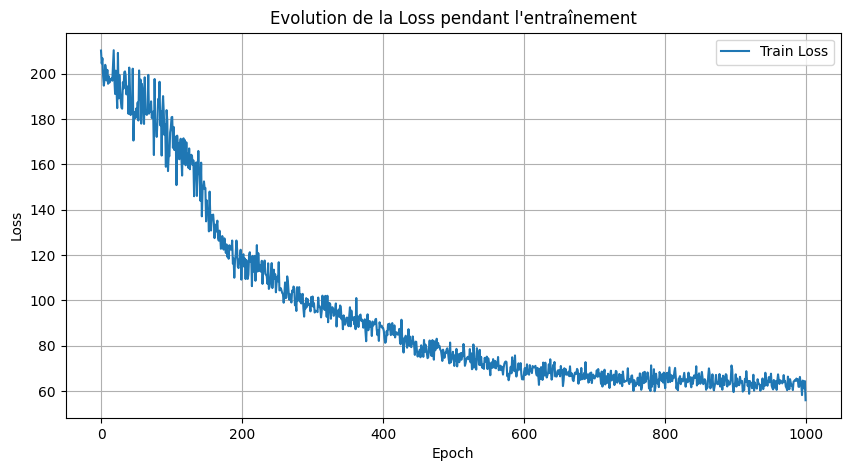

100%|██████████| 1000/1000 [11:45<00:00,  1.42it/s]


In [9]:
model = VAE_Huber_energy(latent_dim = parameters['latent_dim'],
                         encoder = parameters['encoder'],
                         decoder = parameters['decoder'])

model.train(data = training_parameters['dataset'],
            epochs = training_parameters['epochs'],
            batch_size = training_parameters['batch_size'])

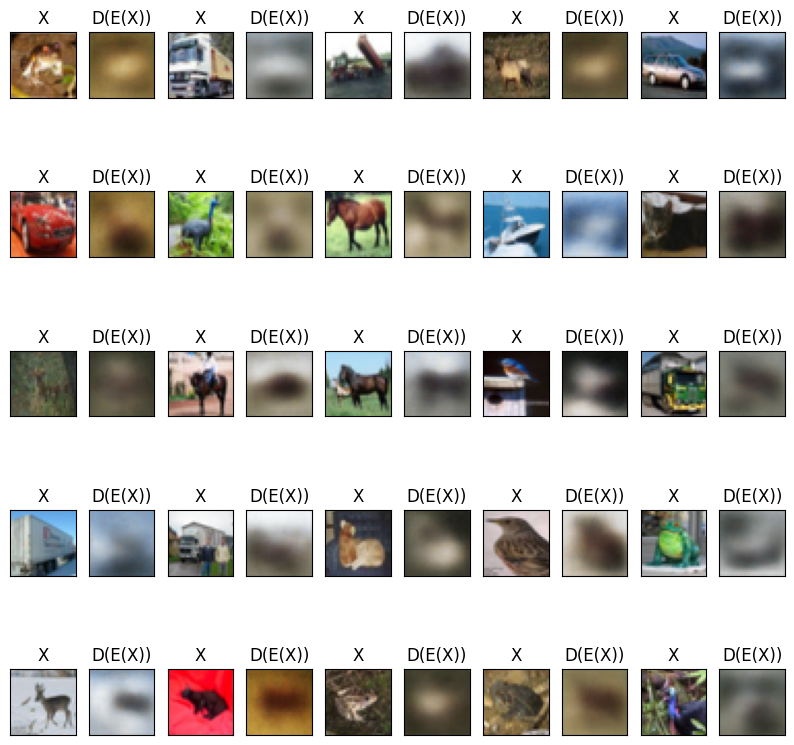

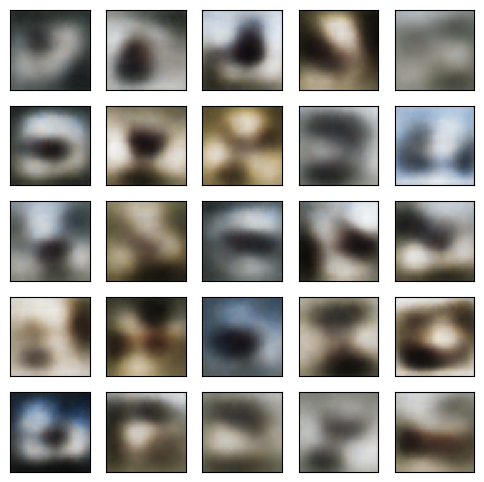

In [10]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,10,2*i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(training_parameters['dataset'][i])
    plt.title("X")

    plt.subplot(5,10,2*i+2)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    _ = model.encoder(tf.expand_dims(training_parameters['dataset'][i], axis = 0))
    decoded_images = model.decoder(_)
    plt.imshow(decoded_images[0])
    plt.title("D(E(X))")
plt.show()

plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = model.decoder(tf.random.normal([1, parameters['latent_dim']]))
    plt.imshow(img[0])
plt.show()


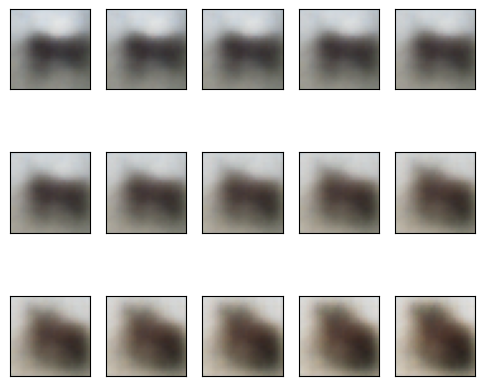

In [11]:
img0 = training_parameters['dataset'][12]
img0_encoded = model.encoder(tf.expand_dims(img0, axis = 0))

img1 = training_parameters['dataset'][18]
img1_encoded = model.encoder(tf.expand_dims(img1, axis = 0))

imgs = [model.decoder([(1-t)*img0_encoded + t*img1_encoded]) for t in np.linspace(0, 1, 15)]

plt.figure(figsize=(6,9))
for i in range(15):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = imgs[i]
    plt.imshow(img[0])
plt.show()

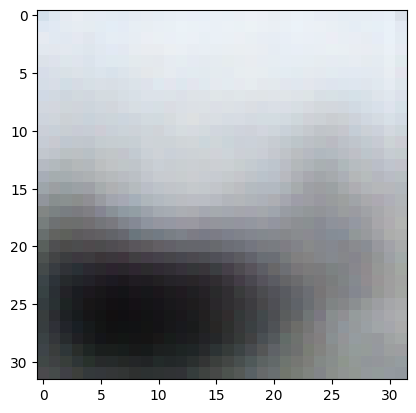

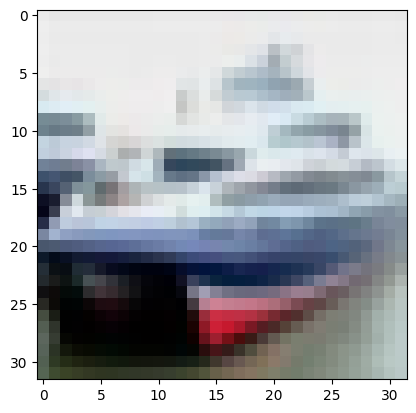

In [28]:
img0 = test_images_cifar10[1]
img0_encoded = model.encoder(tf.expand_dims(img0, axis = 0)/255)
_ = model.decoder(img0_encoded)
plt.imshow(tf.reshape(_, [32,32,3]))
plt.show()
plt.imshow(img0)
plt.show()